In [ ]:
## imports
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


In [ ]:
## Load initial data

out = np.load('disc-benchmark-files/training-val-test-data.npz')
th_train = out['th'] 
u_train = out['u'] 

# Normalise the data

umax = np.max(np.abs(u_train))
thmax = np.max(np.abs(th_train))
u_train = u_train/umax
th_train = th_train/thmax


In [ ]:
def make_OE_data(udata, ydata, nf=100,n_encode = 20):
    U = []
    Y = []
    H = []
    for k in range(nf+n_encode,len(udata)+1):
        U.append(udata[k-nf:k])
        Y.append(ydata[k-nf:k]) 
        H.append(np.concatenate((udata[k-nf-n_encode:k-nf], ydata[k-nf-n_encode:k-nf])))
    return np.array(U), np.array(Y), np.array(H)

# Modify training dataset for training and validation
nf = 40
ne = 20
utrain,ttrain,htrain =make_OE_data(u_train, th_train, nf,ne)
Ut,Uv,Yt,Yv,Ht,Hv = train_test_split(utrain,ttrain,htrain,random_state=42,shuffle=True)
Ut = torch.tensor(Ut)
Uv = torch.tensor(Uv)
Yt = torch.tensor(Yt)
Yv = torch.tensor(Yv)
Ht = torch.tensor(Ht)
Hv = torch.tensor(Hv)
print(f"Ut: {Ut.shape},Uv: {Uv.shape}")
print(f"Yt: {Yt.shape},Yv: {Yv.shape}")
print(f"Ht: {Ht.shape},Hv: {Hv.shape}")

Ut: torch.Size([26205, 40]),Uv: torch.Size([8736, 40])
Yt: torch.Size([26205, 40]),Yv: torch.Size([8736, 40])
Ht: torch.Size([26205, 40]),Hv: torch.Size([8736, 40])


In [ ]:
# Make full dataset for simulation after training
ufull,yfull,hfull = make_OE_data(u_train,th_train,len(u_train)-ne,ne)
ufull = torch.tensor(ufull)
yfull = torch.tensor(yfull)
hfull = torch.tensor(hfull)
print(ufull.shape)
print(yfull.shape)
print(hfull.shape)

torch.Size([1, 34980])
torch.Size([1, 34980])
torch.Size([1, 40])


In [ ]:
# Model
class RNN(nn.Module):
    def __init__(self, hidden_size, n_enc):
        super(RNN, self).__init__()
        self.input_size = 1
        self.output_size = 1
        self.hh = 64

        self.h2h = nn.Sequential(nn.Linear(self.input_size + hidden_size,self.hh),
                                               nn.ReLU(),
                                               nn.Linear(self.hh,hidden_size)).double()

        self.h2o = nn.Sequential(nn.Linear(self.input_size + hidden_size,self.hh),
                                               nn.ReLU(),
                                               nn.Linear(self.hh,self.output_size)).double()
        self.enc = nn.Sequential(
           nn.Linear(2*n_enc,128),
           nn.ReLU(),
           nn.Linear(128,64),
           nn.ReLU(),
           nn.Linear(64,32),
           nn.ReLU(),
           nn.Linear(32,hidden_size)).double()
    def forward(self, x, hist):
        hidden = self.enc(hist)
        outputs = []
        for i in range(x.shape[1]):
            u = x[:,i][:,None]
            temp = torch.cat((hidden,u),1)
            outputs.append(self.h2o(temp)[:,0])
            hidden = self.h2h(temp)
        return torch.stack(outputs,dim =1)


In [ ]:
# Training
epochs = 100
batch_size = 64

model =RNN(15,ne)
opt = torch.optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.MSELoss()
ids=np.arange(len(Ut),dtype = int)
Losses = []
Losses_val = []
for epoch in range(epochs):
    np.random.shuffle(ids)
    for i in range(0,len(ids),batch_size):
        # batching
        id_batch = ids[i:i+batch_size]
        Ub = Ut[id_batch]
        Hb = Ht[id_batch]
        Yb = Yt[id_batch]

        Y_pred = model(Ub,Hb)
        Loss = torch.mean((Y_pred - Yb)**2)
        opt.zero_grad()
        Loss.backward()
        opt.step()
    with torch.no_grad():
        Loss_val = torch.mean((model(Uv,Hv) - Yv)**2)**0.5
        Loss_train = torch.mean((model(Ut,Ht) - Yt)**2)**0.5
        Losses.append(Loss_train.item())
        Losses_val.append(Loss_val.item())
        print(f'Epoch={epoch}, Validation Loss={Loss_val.item():}, Train Loss={Loss_train.item():}')

epoch=0, Validation Loss=0.16892624404716314, Train Loss=0.16738650412649894
epoch=1, Validation Loss=0.03620257463781008, Train Loss=0.03695771205798532
epoch=2, Validation Loss=0.026357741631221343, Train Loss=0.026961157580674026
epoch=3, Validation Loss=0.021042737701596984, Train Loss=0.021548729012475086
epoch=4, Validation Loss=0.01875490634396723, Train Loss=0.01871836304768957
epoch=5, Validation Loss=0.01714111276656955, Train Loss=0.01688594720330921
epoch=6, Validation Loss=0.017129447773484067, Train Loss=0.01675409258897175
epoch=7, Validation Loss=0.01556896859414347, Train Loss=0.01507406939724648
epoch=8, Validation Loss=0.014690120099421767, Train Loss=0.014300515014715626
epoch=9, Validation Loss=0.0134030754691426, Train Loss=0.012907551228366485
epoch=10, Validation Loss=0.013780088235276733, Train Loss=0.01332976522125048
epoch=11, Validation Loss=0.013541421252951292, Train Loss=0.012938480175482582
epoch=12, Validation Loss=0.01217518417227231, Train Loss=0.0116

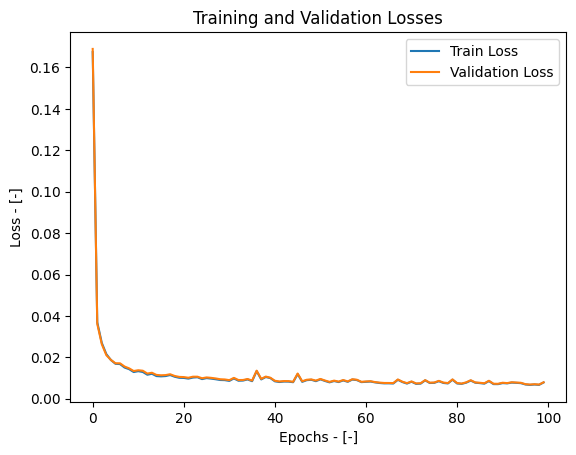

In [ ]:
# Plotting losses   
plt.plot(Losses, label='Train Loss')
plt.plot(Losses_val, label='Validation Loss')
plt.xlabel('Epochs - [-]')
plt.ylabel('Loss - [-]')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

torch.Size([1, 34980])


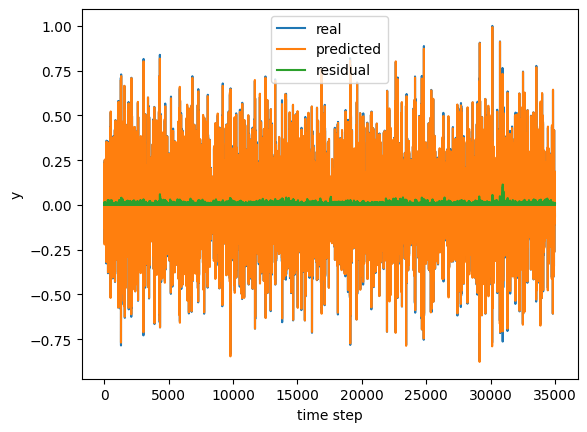

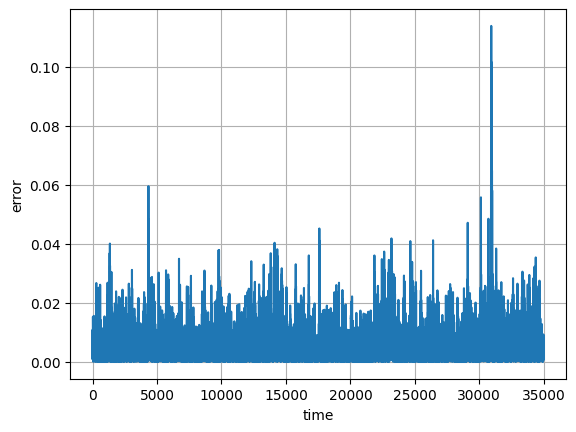

0.009434487566542912


In [ ]:
# Run simulation
print(yfull.shape)
with torch.no_grad():
    plt.plot(yfull.T)
    plt.plot(model(ufull,hfull).T)
    plt.plot(np.mean((yfull.T-model(ufull,hfull).T).numpy()**2,axis=1)**0.5)
    plt.xlabel('time step')
    plt.ylabel('y')
    plt.legend(['real','predicted','residual'])
    plt.show()
    
    plt.plot(np.mean((yfull.T-model(ufull,hfull).T).numpy()**2,axis=1)**0.5)
    plt.ylabel('error')
    plt.xlabel('time')
    plt.grid()
    plt.show()
print(np.mean((yfull-model(ufull,hfull)).detach().numpy()**2)**0.5)


In [ ]:
# Simulate submission
data = np.load('disc-benchmark-files/hidden-test-simulation-submission-file.npz')
upast_test = data['u'] / umax
thpast_test = data['th'] 
thsub = thpast_test.copy() / thmax
th_in = thpast_test.copy() / thmax
ufull,yfull,hfull = make_OE_data(upast_test,th_in,len(upast_test)-ne,ne)
out = model(torch.tensor(ufull),torch.tensor(hfull)).detach().numpy()
thsub[ne:] = out
np.savez('submissions/adv_sim.npz', u=upast_test*umax, th=thsub* thmax)